In [1]:
from inverse_modelling_tfo.models import train_model, create_perceptron_model
from inverse_modelling_tfo.data import generate_data_loaders, normalize_zero_mean, interpolate_exp
from torch.optim import Adam, SGD
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
import pandas as pd

# Can We Fit All Datapoints at Once?

In [2]:
# Example Code
np.random.seed(42)  # Set seed for consistentcy
params = {
    'batch_size': 10000, 'shuffle': False, 'num_workers': 2
}

# Load Data
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/test_data.pkl')
data = interpolate_exp(data, weights=[1, -3])
data = normalize_zero_mean(data)

In [3]:
data.head()

,SDD,Intensity,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a,Interpolated Intensity
0,0.00,0.819658,0.5,0.25,-0.3,0.0,0.0,0.819527
1,0.25,0.709747,0.5,0.25,-0.3,0.0,0.0,0.708003
2,0.45,0.617316,0.5,0.25,-0.3,0.0,0.0,0.624728
3,0.70,0.527734,0.5,0.25,-0.3,0.0,0.0,0.525488
4,0.95,0.437506,0.5,0.25,-0.3,0.0,0.0,0.430140


In [4]:
# MERGE Wave Ints
data = data.pivot_table(index=['Uterus Thickness', 'Maternal Wall Thickness', 'Maternal Mu_a', "Fetal Mu_a", 'Wave Int'], columns='SDD', values='Interpolated Intensity').reset_index()
# data = data.pivot_table(index=['Uterus Thickness', 'Maternal Wall Thickness', 'Maternal Mu_a', "Fetal Mu_a", 'Wave Int'], columns='SDD', values='Intensity').reset_index()

# Since we pivot on 2 columns, the dataframe now has multi-index. Which is essentially a Tuple. Making the tuple into a single word
# data.columns = [str(col[0]) + str(col[1]) for col in data.columns.values]

x_columns = ['Uterus Thickness', 'Maternal Wall Thickness', 'Maternal Mu_a', "Fetal Mu_a", 'Wave Int']
y_columns = list(data.columns)
for column_name in x_columns:
    y_columns.remove(column_name)

train, val = generate_data_loaders(data, params, x_columns, y_columns, train_split=0.8)

In [5]:
model = create_perceptron_model([5, 10, 20])
print(model)

Sequential(
  (0): Linear(in_features=5, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=20, bias=True)
  (3): Flatten(start_dim=1, end_dim=-1)
)


In [11]:
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.005)
# optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=50)

In [8]:
print('Train Error', train_loss[-5:])
print('Val. Error', validation_loss[-5:])

Train Error [0.028824614360928535, 0.02736419253051281, 0.02600575052201748, 0.024745583534240723, 0.02357906475663185]
Val. Error [0.028941957280039787, 0.027499796822667122, 0.026164889335632324, 0.024931449443101883, 0.023792987689375877]


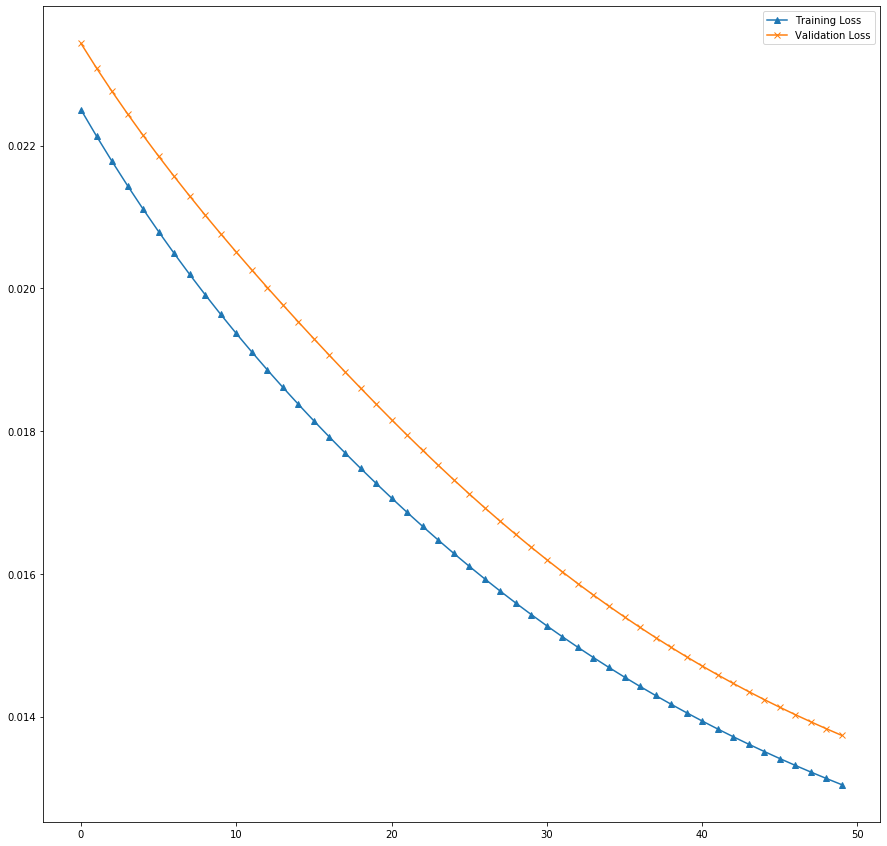

In [13]:
plt.figure(figsize=(15, 15))
plt.plot(train_loss, label='Training Loss', marker='^')
plt.plot(validation_loss, label='Validation Loss', marker='x')
plt.legend()

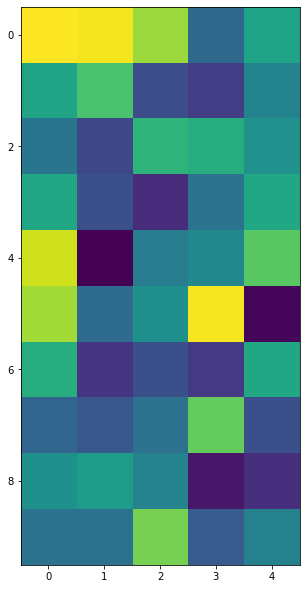

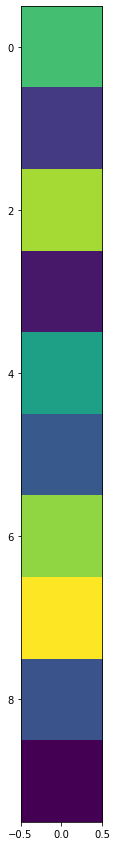

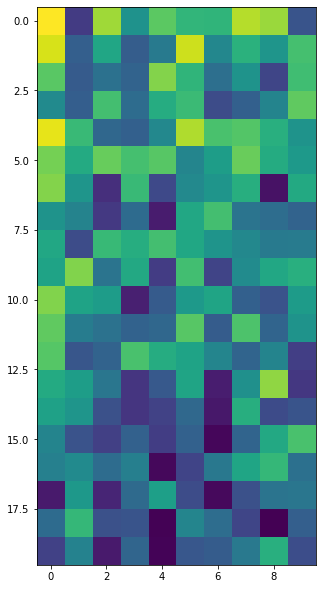

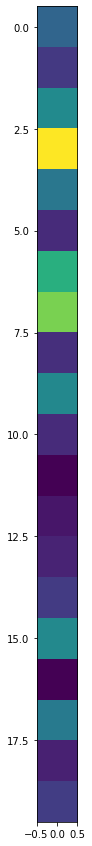

In [10]:
params = model.parameters()
for x in params:
    print
    plt.figure(figsize=(5, 15))
    if len(x.shape) == 1:
        plt.imshow(x.cpu().view(-1, 1).detach().numpy())
    else:    
        plt.imshow(x.cpu().detach().numpy())
